In [1]:
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt
from copy import copy
import onnxruntime
from scipy import ndimage
from itertools import product


Bad key text.latex.unicode in file /Users/Mikhail.Shagvaliev/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /Users/Mikhail.Shagvaliev/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /Users/Mikhail.Shagvaliev/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably ne

## Constants

In [2]:
DATASET_DESCRIPTION = "../data/description/data.json"

## Load data

In [3]:
with open(DATASET_DESCRIPTION, "r") as file:
  data_description = json.load(file)
  captures = data_description["captures"]

## Load and show image

In [4]:
def load_image(path: str):
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_images(images: list):
  _, axs = plt.subplots(len(images), figsize=(16, 16*len(images)))
  print(axs)
  if len(images) == 1:
    axs.imshow(images[0], cmap="gray")
  else:
    axs = axs.flatten()
    for img, ax in zip(images, axs):
      ax.imshow(img, cmap="gray")
  plt.show()


In [5]:
original_image = load_image("../examples/fit/32_fit.png")

AxesSubplot(0.125,0.125;0.775x0.755)


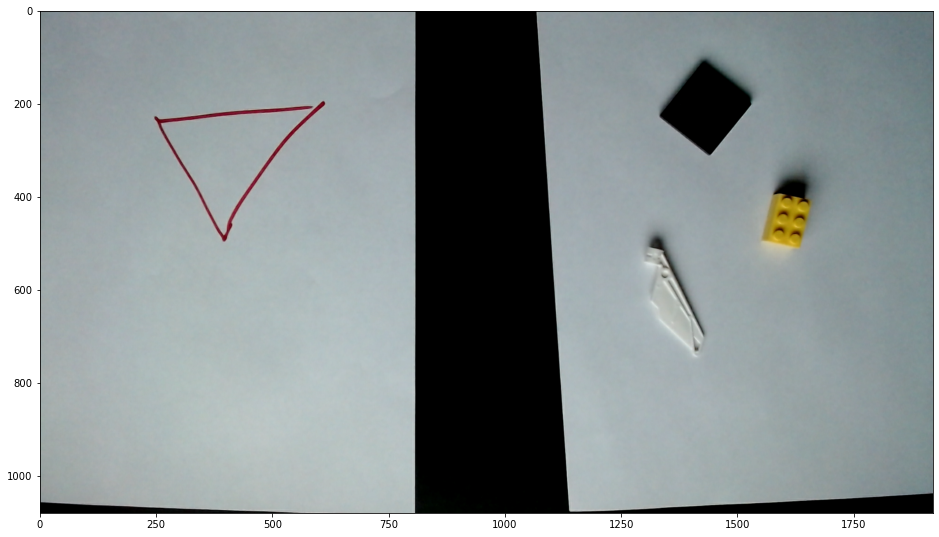

In [6]:
plot_images([original_image])

In [7]:
def process_image(image, image_processors: list):
  for processor in image_processors:
    image = processor(image)

  return image

In [8]:
def process_image_and_plot_image_transformations(image, image_processors: list):
  image_transformations = [image]
  for processor in image_processors:
    image_transformations.append(processor(image_transformations[-1]))

  plot_images(image_transformations)

## Subtract background from original image

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:>]


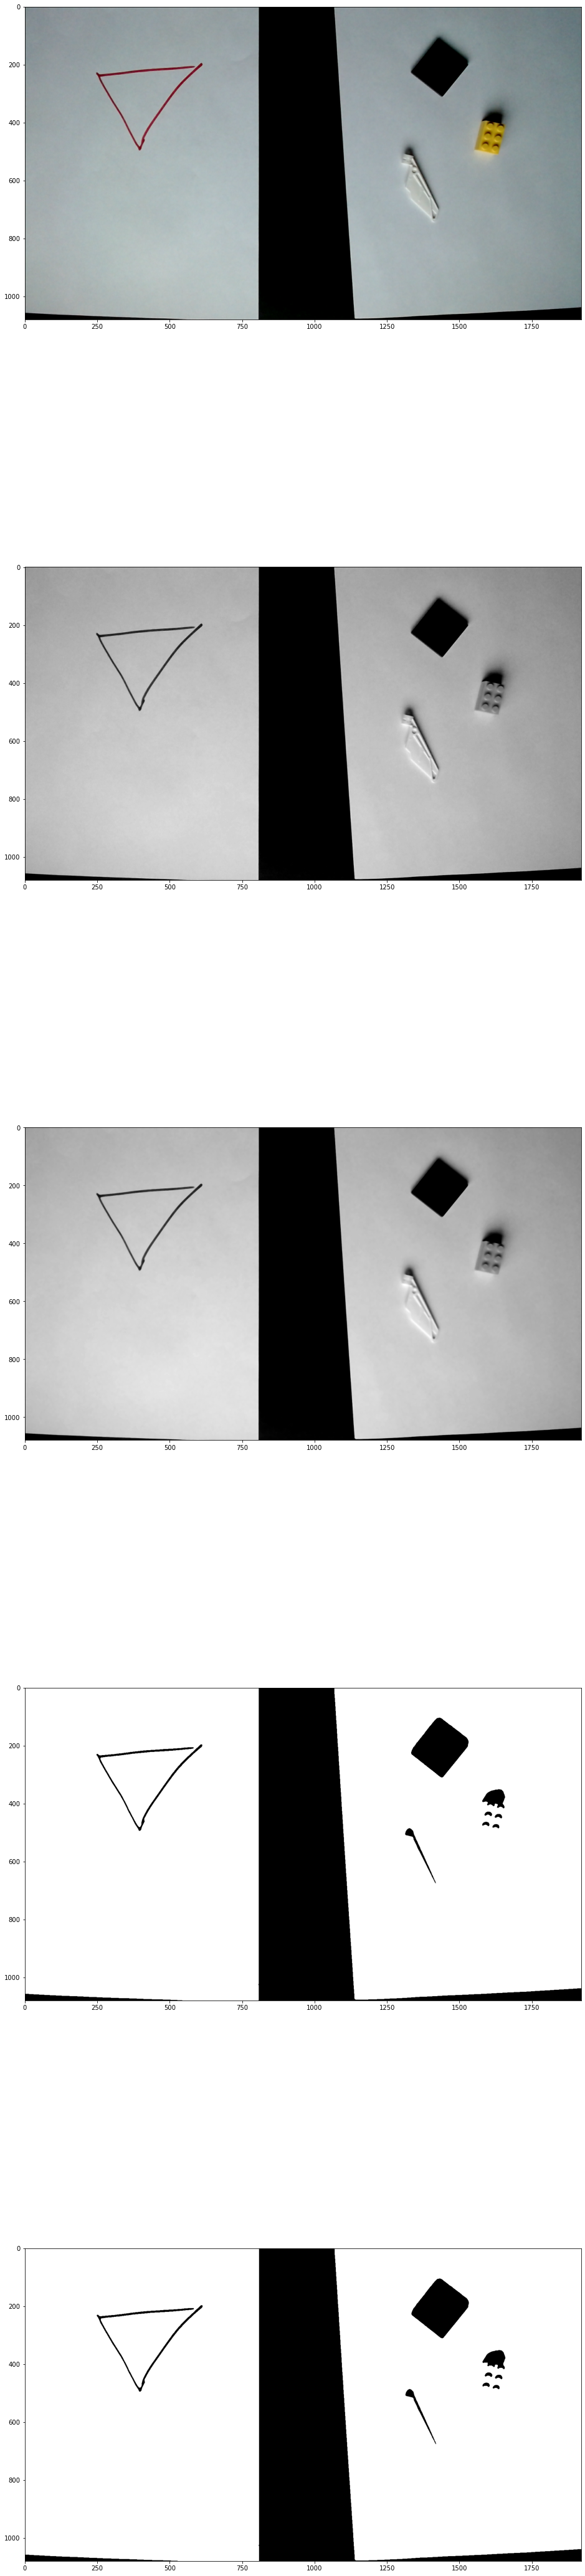

In [9]:
process_pipeline = [
  lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
  lambda img: cv2.medianBlur(img, ksize=7),
  lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1],
  lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((6, 6)))
]

process_image_and_plot_image_transformations(original_image, process_pipeline)

mask = process_image(original_image, process_pipeline)

## Get contour of paper sheets

In [10]:
def get_outer_contours_by_mask(mask):
  contours, _ = cv2.findContours(copy(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

In [11]:
def get_bboxes_by_mask(mask):
  return [cv2.boundingRect(contour) for contour in get_outer_contours_by_mask(mask)]

In [12]:
def draw_contours(image, contours):
  image = copy(image)
  cv2.drawContours(image, contours, -1, (0, 0, 255), 3)
  return image

In [13]:
def draw_bboxes(image, bboxes):
    image = copy(image)
    for i, (x, y, w, h) in enumerate(bboxes):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 3)
        cv2.putText(image, f'{i}', (x, y+h), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness=5)

    return image

AxesSubplot(0.125,0.125;0.775x0.755)


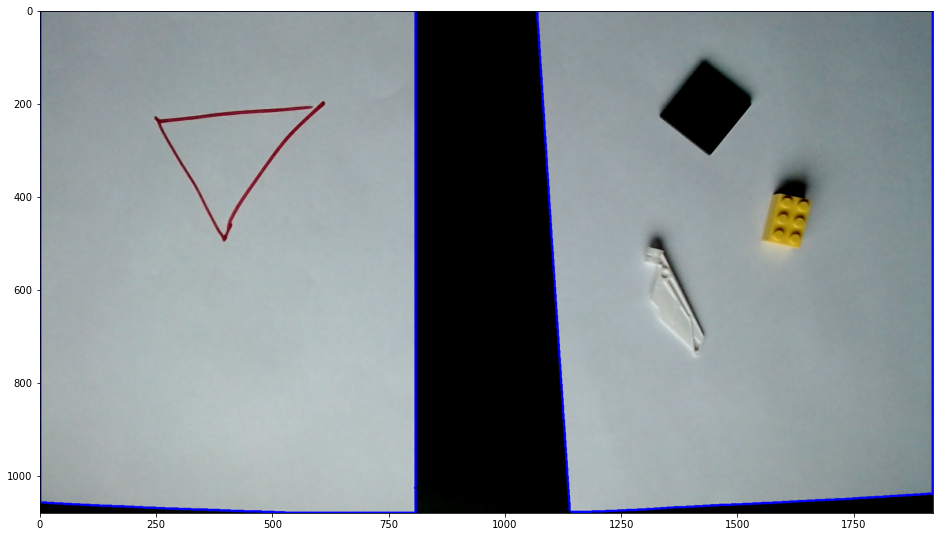

In [14]:
plot_images([draw_contours(original_image, get_outer_contours_by_mask(mask))])

## Get masks of paper sheets

In [15]:
def get_mask_by_contour(image, contour):
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, [contour], (255, 255, 255))
  return mask

def get_papers_masks(image, mask):
  contours = get_outer_contours_by_mask(mask)
  assert len(contours) > 0
  if len(contours) == 1:
    return [get_mask_by_contour(image, contours[0])]

  papers_contours = list(sorted(contours, key=lambda contour: cv2.contourArea(contour))[-2:])
  paper_contours_from_left_to_right = list(sorted(papers_contours, key=lambda contour: cv2.boundingRect(contour)[0]))

  return tuple([get_mask_by_contour(image, contour) for contour in paper_contours_from_left_to_right])

[<AxesSubplot:> <AxesSubplot:>]


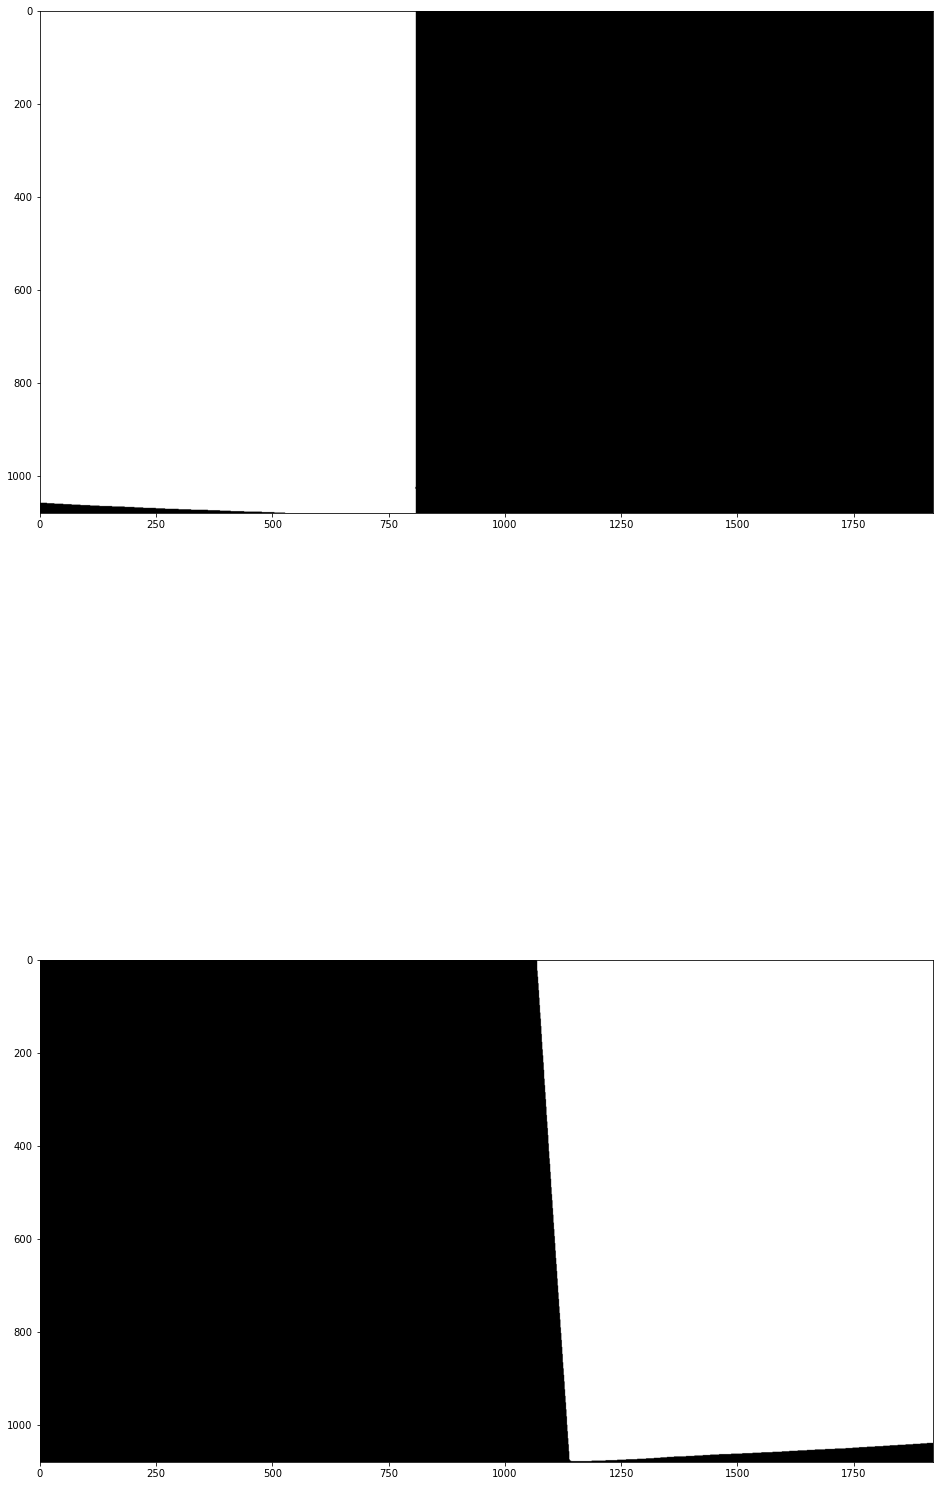

In [16]:
plot_images(get_papers_masks(original_image, mask))

## Separate left and right paper sheets

In [17]:
def apply_mask(image, mask):
  mask_boolean = mask != (255, 255, 255)
  if image.ndim == 2:
    mask_channels = [mask_boolean[:, :, i] for i in (0, 1, 2)]
    mask_boolean = np.logical_or(*mask_channels)

  return np.where(mask_boolean, 0, image)

In [18]:
image_papers_separated = [apply_mask(original_image, paper_mask) for paper_mask in get_papers_masks(original_image, mask)]

[<AxesSubplot:> <AxesSubplot:>]


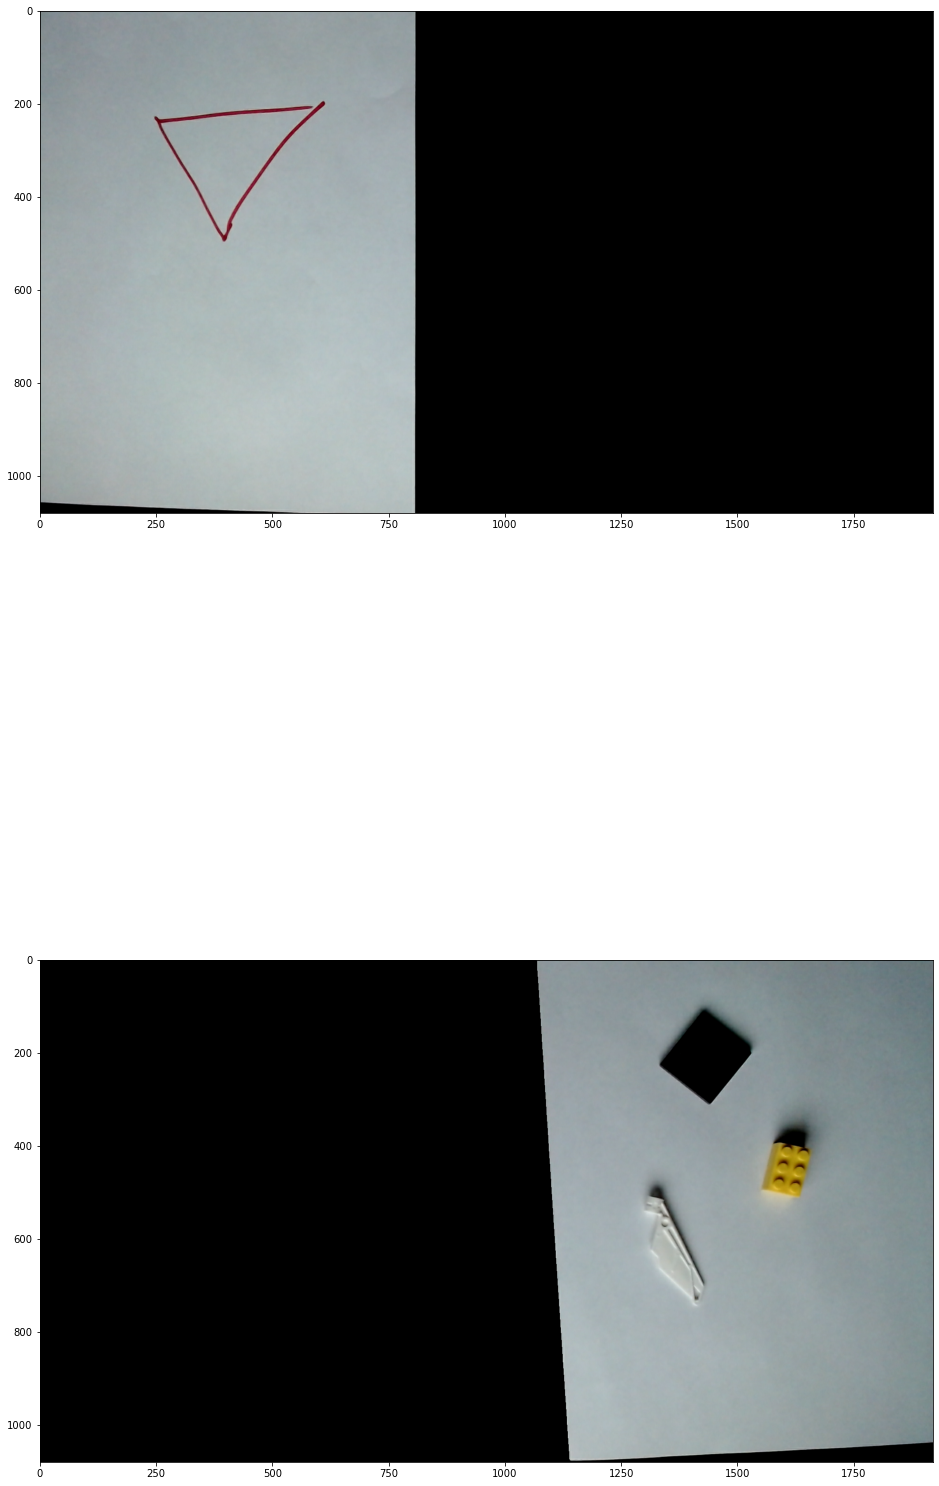

In [19]:
plot_images(image_papers_separated)

## Process left paper sheet (one with the area)

In [20]:
paper_mask_left, paper_mask_right = get_papers_masks(original_image, mask)
image_paper_left, image_paper_right = image_papers_separated

In [ ]:
def get_left_paper_processors(paper_mask_left):
  dilate_kernel = np.asarray([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
  ], dtype=np.uint8)

  return [
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    lambda img: cv2.medianBlur(img, ksize=7),
    lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1],
    lambda mask: apply_mask(mask, paper_mask_left),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=np.ones((2, 2)), iterations=2),
    lambda mask: cv2.dilate(mask, dilate_kernel, iterations=5)
  ]

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


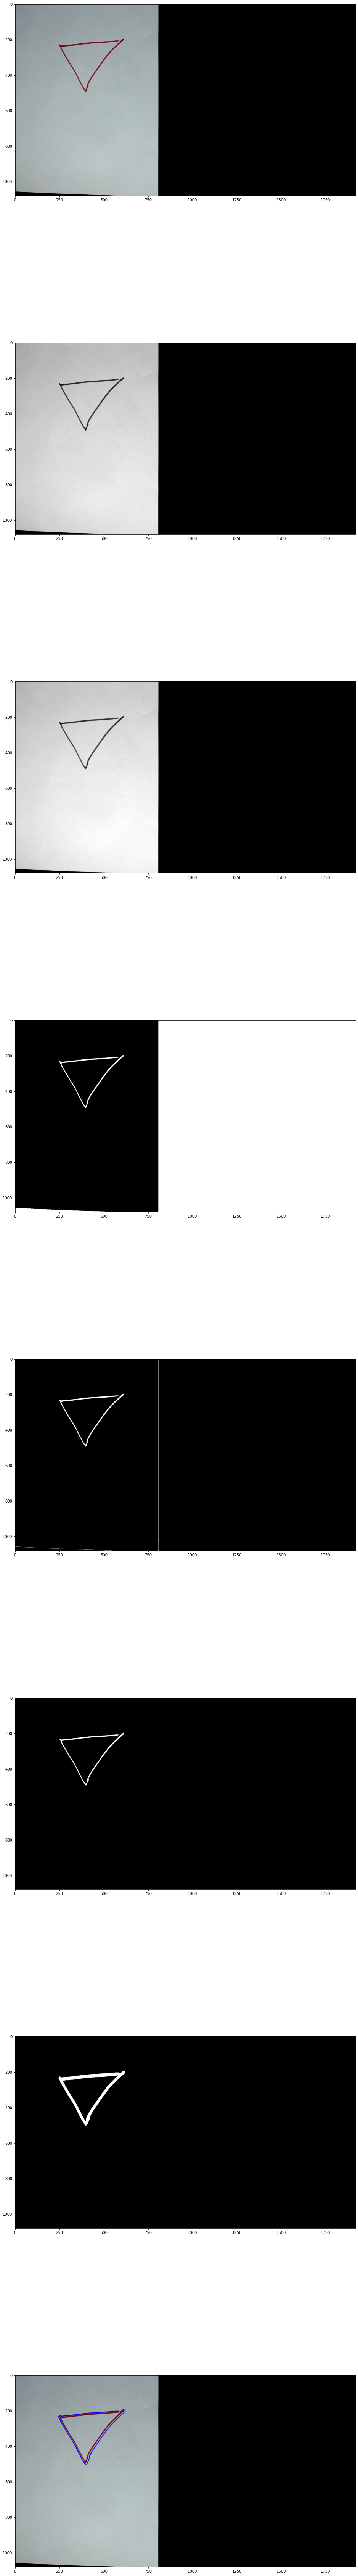

In [21]:
def plot_left_paper_processing(image_paper_left, paper_mask_left):
  return process_image_and_plot_image_transformations(
    image_paper_left,
    get_left_paper_processors(paper_mask_left) + [lambda mask: draw_contours(image_paper_left, get_outer_contours_by_mask(mask))]
  )

In [ ]:
plot_left_paper_processing(image_paper_left, paper_mask_left)

## Process the right paper (with the objects), get approximate contours for them (no need to be exact, since we'll just cut a 256x256 parts of the image with that contours)

In [ ]:
def get_right_paper_mask_processors(paper_mask_right):
  background_mask = cv2.bitwise_not(paper_mask_right)
  background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_DILATE, kernel=np.ones((30, 30)), borderType=cv2.BORDER_REFLECT)
  background_mask = cv2.bitwise_not(background_mask)

  def laplacian_edge(img):
    ddepth = cv2.CV_16S
    kernel_size = 5
    dst = cv2.Laplacian(img, ddepth, ksize=kernel_size)
    abs_dst = cv2.convertScaleAbs(dst)
    return abs_dst

  return [
    lambda img: cv2.medianBlur(img, ksize=13),
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    lambda img: laplacian_edge(img),
    lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1],
    lambda mask: apply_mask(mask, background_mask),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel=np.ones((4, 4)), borderType=cv2.BORDER_REFLECT),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((40, 40)))
  ]

In [ ]:
def plot_process_right_paper(image_paper_right, paper_mask_right):
  right_paper_processors = get_right_paper_mask_processors(paper_mask_right)
  process_image_and_plot_image_transformations(image_paper_right, right_paper_processors)

In [ ]:
plot_process_right_paper(image_paper_right, paper_mask_right)

In [24]:
def crop_image_to_bbox(image, bbox, shape_to_crop):
    x_bb, y_bb, w_bb, h_bb = bbox

    # transform x, y, w, h to coordinates of middle points, and w/2, h/2
    x_bb, y_bb, w_bb, h_bb = x_bb + w_bb // 2, y_bb + h_bb // 2, w_bb // 2, h_bb // 2

    H_img, W_img, _ = image.shape

    # x, y, w, h are the characteristics of crop region
    w, h = shape_to_crop[1] // 2, shape_to_crop[0] // 2

    def get_crop_region_mid_coord_along_axis(w, x_bb, w_bb, W_img):
        if w_bb > w:
            return x_bb, w_bb

        # mid x must be in [x_min, x_max]
        x_min = max(x_bb + w_bb - w, w)
        x_max = min(W_img - w, x_bb - w_bb + w)

        if x_min <= x_bb <= x_max:
            return x_bb, w

        return (x_min, w) if x_bb < x_min else (x_max, w)

    # middle coordinates of crop region
    x, w = get_crop_region_mid_coord_along_axis(w, x_bb, w_bb, W_img)
    y, h = get_crop_region_mid_coord_along_axis(h, y_bb, h_bb, H_img)

    # transform coordinates back
    x_bb, y_bb, w_bb, h_bb = x_bb - w_bb, y_bb - h_bb, 2 * w_bb, 2 * h_bb
    x, y, w, h = x - w, y - h, 2 * w, 2 * h

    # calculate end coordinates of regions (crop and bbox)
    x_end, y_end, x_bb_end, y_bb_end = x + w, y + h, x_bb + w_bb, y_bb + h_bb

    # fit bbox to cropped region
    def get_bbox_coords_along_axis(all_coords):
        all_coords = sorted(all_coords)
        return all_coords[1], all_coords[2]

    x_bb, x_bb_end = get_bbox_coords_along_axis([x, x_bb, x_bb_end, x_end])
    y_bb, y_bb_end = get_bbox_coords_along_axis([y, y_bb, y_bb_end, y_end])

    # update bounding box relative to cropped region
    x_bb, y_bb, w_bb, h_bb = x_bb - x, y_bb - y, x_bb_end - x_bb, y_bb_end - y_bb

    img_res = image[y:y + h, x:x + w]
    if w > shape_to_crop[1] or h > shape_to_crop[0]:
        img_res = cv2.resize(img_res, (shape_to_crop[1], shape_to_crop[0]))

    return img_res, (x_bb, y_bb, w_bb, h_bb)

In [ ]:
def get_crops_with_objects(image, contours):
  assert len(contours) > 0

  crops = []
  for contour in contours:
    bbox_object = cv2.boundingRect(contour)
    crop, _ = crop_image_to_bbox(image, bbox_object, (256, 256))
    crops.append(crop)

  return crops

In [ ]:
def get_cropped_objects(image_paper_right, paper_mask_right):
  objects_mask = process_image(image_paper_right, get_right_paper_mask_processors(paper_mask_right))
  crops = get_crops_with_objects(image_paper_right, get_outer_contours_by_mask(objects_mask))
  return crops

In [ ]:
plot_images(get_cropped_objects(image_paper_right, paper_mask_right))

In [ ]:
PATH_MODEL = "../model/model.onnx"

In [ ]:
ort_session = onnxruntime.InferenceSession(PATH_MODEL)

In [ ]:
PATH_MASKS_MAPPING = "../data/perfect_masks/id_to_mask.json"

In [ ]:
with open(PATH_MASKS_MAPPING, "r") as file:
  PERFECT_MASK_MAPPING = json.load(file)

In [ ]:
def predict_bricks_ids(ort_session, crops):
  crops_in_batch = np.asarray(crops).transpose((0, 3, 1, 2)).astype(np.float32) / 255.0

  ort_inputs = {ort_session.get_inputs()[0].name: crops_in_batch}
  ort_outs = ort_session.run(None, ort_inputs)
  predictions = ort_outs[0].argmax(axis=1)
  return predictions

In [ ]:
PATH_MASKS = "../data/perfect_masks"

def predict_perfect_masks(ort_session, crops):
  predictions = predict_bricks_ids(ort_session, crops)

  perfect_masks = []
  for prediction in predictions:
    mask_path = os.path.join(PATH_MASKS, PERFECT_MASK_MAPPING[str(prediction)])
    perfect_masks.append(load_image(mask_path))

  return perfect_masks

In [ ]:
plot_images(predict_perfect_masks(ort_session, get_cropped_objects(image_paper_right, paper_mask_right)))

In [ ]:
def create_brick_mask_on_map(brick_id, initial_position, initial_rotation=0):
  PATH_MASKS_MAPPING = "../data/perfect_masks/id_to_mask.json"

  with open(PATH_MASKS_MAPPING, "r") as file:
    perfect_mask_mapping = json.load(file)

  mask_path = os.path.join(PATH_MASKS, perfect_mask_mapping[str(brick_id)])
  _, mask = cv2.threshold(load_image(mask_path), 254, 255, cv2.THRESH_BINARY)
  mask = mask[:, :, 0]
  mask = mask / 255
  return BrickMaskOnMap(mask, initial_position, initial_rotation)


class BrickMaskOnMap:
  def __init__(self, mask, initial_position, initial_rotation=0):
    self.mask = mask
    initial_position = np.asarray(initial_position)
    self.positions = [initial_position]
    self.rotations = [initial_rotation]

  def current_position(self):
    return np.sum(self.positions, axis=0)

  def current_rotation(self):
    return np.sum(self.rotations)

  def clone(self):
    cloned = BrickMaskOnMap(self.mask, None, None)
    cloned.positions = copy(self.positions)
    cloned.rotations = copy(self.rotations)
    return cloned

  def generate_same_position_new_rotation(self):
    res = self.clone()
    rotation_change = int(np.random.uniform(0, 360, 1)[0])
    res.positions.append(np.asarray([0, 0]))
    res.rotations.append(rotation_change)
    return res

  def generate_new_position_new_rotation(self):
    print(f"old position {self.current_position()}")
    res = self.generate_same_position_new_rotation()
    position_change = np.random.normal(0, 50, 2).astype(int)
    res.positions[-1] = position_change
    print(f"new position {res.current_position()}")
    return res

  def rotate_mask(self):
    mask_rotated = ndimage.rotate(self.mask, self.current_rotation(), reshape=True)
    return mask_rotated

  def apply_on_map(self, map):
    final_mask = self.rotate_mask()

    h, w = final_mask.shape
    print(f"POS: {self.current_position()}")
    pos_x, pos_y = self.current_position() - np.asarray([w//2, h//2])
    print(f"pos x : {pos_x}, pos y : {pos_y}")
    print(f"rotated shape: {h}, {w}")
    print(f"layout shape: {map[pos_y:pos_y+h, pos_x:pos_x+w].shape}")
    try:
      map[pos_y:pos_y+h, pos_x:pos_x+w] += final_mask
    except:
      print("failed")
      map[:, :] = 999999

In [ ]:
def get_area_crop(image_paper_left, paper_mask_left):
  area_border_mask = process_image(image_paper_left, get_left_paper_processors(paper_mask_left))
  contour = get_outer_contours_by_mask(area_border_mask)[0]

  all_area = np.zeros_like(area_border_mask)
  cv2.drawContours(all_area, [contour], -1, 255, thickness=cv2.FILLED)

  crop = cv2.boundingRect(contour)
  x, y, w, h = crop

  res = all_area[y:y+h, x:x+w]
  _, res = cv2.threshold(res, 254, 255, cv2.THRESH_BINARY)
  return res

In [ ]:
plot_images([get_area_crop(image_paper_left, paper_mask_left)])

In [ ]:
MAP_SHAPE = np.asarray([2000, 2000])
MAP_OUTSIDE_VALUE = -1000

def generate_map(area_crop):
  map = np.ones(MAP_SHAPE) * MAP_OUTSIDE_VALUE

  contour = get_outer_contours_by_mask(area_crop)[0]
  area = np.ones_like(area_crop) * MAP_OUTSIDE_VALUE
  cv2.fillPoly(area, [contour], 1)

  area_h, area_w = area_crop.shape
  pos_x, pos_y = MAP_SHAPE//2 - np.asarray([it//2 for it in area_crop.shape])
  map[pos_y:pos_y+area_h, pos_x:pos_x+area_w] = area
  return map

In [ ]:
map = generate_map(get_area_crop(image_paper_left, paper_mask_left))

In [ ]:
def plot_map(map):
  map_to_plot = copy(map)
  map_to_plot[map_to_plot == MAP_OUTSIDE_VALUE] = 0
  map_to_plot[map_to_plot < 0] = 0

  d = np.max(map_to_plot)
  map_to_plot = map_to_plot / d * 255
  plot_images([map_to_plot])

plot_map(map)

In [ ]:
def generate_map_with_bricks(map, bricks_ids):
  mid_point = np.asarray(map.shape) // 2
  bricks = [create_brick_mask_on_map(brick_id, mid_point) for brick_id in bricks_ids]

  map_with_bricks = copy(map)
  for brick in bricks:
    brick.apply_on_map(map_with_bricks)

  return map_with_bricks

In [ ]:
def get_loss_on_map(map):
  OUT_OF_BORDER_COEF = 10
  loss_from_out_of_border = np.count_nonzero(np.logical_and(map > MAP_OUTSIDE_VALUE, map < 0)) * OUT_OF_BORDER_COEF
  loss_from_objects_intersection = np.count_nonzero(map > 1)
  return loss_from_objects_intersection + loss_from_out_of_border

In [ ]:
def generate_bricks(map, bricks_ids):
  mid_point = np.asarray(map.shape) // 2
  return [create_brick_mask_on_map(brick_id, mid_point) for brick_id in bricks_ids]

In [ ]:
def generate_map_with_bricks(map, bricks_ids):
  bricks = generate_bricks(map, bricks_ids)

  map_with_bricks = copy(map)
  for brick in bricks:
    brick.apply_on_map(map_with_bricks)

  return map_with_bricks

In [ ]:
map_with_bricks = generate_map_with_bricks(map, predict_bricks_ids(ort_session, get_cropped_objects(image_paper_right, paper_mask_right)))

In [ ]:
get_loss_on_map(map_with_bricks)

In [ ]:
plot_map(map_with_bricks)

In [ ]:
def generate_new_bricks(bricks, num_bricks_new_positions=10, num_bricks_new_rotation=10):
  new_bricks = [[] for _ in range(len(bricks))]
  for i, brick in enumerate(bricks):
    brick: BrickMaskOnMap
    new_bricks[i] = new_bricks[i] + [brick.generate_same_position_new_rotation() for _ in range(num_bricks_new_rotation)]
    new_bricks[i] = new_bricks[i] + [brick.generate_new_position_new_rotation() for _ in range(num_bricks_new_positions)]

  return new_bricks

In [ ]:
def one_iteration(map, old_bricks):
  map_for_old_bricks = copy(map)
  for brick in old_bricks:
    brick.apply_on_map(map_for_old_bricks)

  min_loss = get_loss_on_map(map_for_old_bricks)
  best_bricks_combination = old_bricks

  new_bricks = generate_new_bricks(old_bricks)
  bricks_combinations = list(product(*new_bricks))
  for i, brick_combination in enumerate(bricks_combinations):
    print(f"{i} OUT OF {len(bricks_combinations)}")
    map_for_new_combination = copy(map)
    brick_combination = list(brick_combination)
    for brick in brick_combination:
      brick.apply_on_map(map_for_new_combination)

    loss = get_loss_on_map(map_for_new_combination)
    if (loss < min_loss):
      print("BETTER")
      min_loss = loss
      best_bricks_combination = brick_combination

    #plot_map(map_for_new_combination)

  res_map = copy(map)
  for brick in best_bricks_combination:
    brick.apply_on_map(res_map)

In [ ]:
plot_map(
  one_iteration(
    map,
    generate_bricks(map, predict_bricks_ids(ort_session, get_cropped_objects(image_paper_right, paper_mask_right)))
  )
)